# Clustering of Locations & Relocation of Scooters

## Preparations

modules

In [1]:
import pandas as pd  # working with dataframes
import numpy as np  # simple functions for vectors and matrices
import matplotlib.pyplot as plt  # simple plotting
from seaborn import color_palette  # color palette
from sklearn.preprocessing import StandardScaler, MinMaxScaler  # scale features before clustering
from sklearn.decomposition import PCA  # PCA for 3D cluster plotting
from sklearn.mixture import GaussianMixture  # GMM for clustering
from plotly.offline import init_notebook_mode, iplot  # interactive plotting
from helper_functions import create_cluster_space, allocate_scooters  # own functions

options

In [2]:
# automatic reloading of modules and functions before each cell
%load_ext autoreload
%autoreload 2

In [3]:
# panda reassignment of columns
pd.options.mode.chained_assignment = None

In [4]:
# plotting
%matplotlib inline
plt.style.use(['dark_background'])
plt.rc('figure', figsize=(20.0, 10.0))
init_notebook_mode()
colors = color_palette('bright').as_hex()

loading data

In [5]:
features_scooter = pd.read_csv('data/features_scooter.csv', index_col=0)
features_location = pd.read_csv('data/features_location.csv', index_col=[0,1])
scooter_last_location = pd.read_csv('data/scooter_last_location.csv', index_col=0)

## Clustering the locations

We will look at three different clusters assuming a difference in high, medium and low demand. For clustering we don't consider the indicator features.

In [6]:
K = 3
feats = features_location.drop(['rent_start', 
                                'zone_entered', 'zone_left',
                                'early_peak', 'late_peak'], axis=1).values

In [7]:
standardizer = StandardScaler()
standardized_feats = standardizer.fit_transform(feats)

In [8]:
gm = GaussianMixture(n_components=K, tol=0.0001, max_iter=1000, n_init=10)
gm.fit(standardized_feats)
predictions = gm.predict(standardized_feats)

In [9]:
cluster_proportions = pd.DataFrame(columns=[0,1,2], data=gm.weights_.reshape(-1,3))
cluster_proportions

0         1        2
0  0.210237  0.347453  0.44231

Looks somehow evenly distributed/sized.

## Principal Component Analysis (PCA)

We perform a PCA creating three principal components. This is important for plotting a projection on three axes and see if the clustering works.

In [10]:
pca = PCA(n_components=3)
pca.fit(standardized_feats)
basis_vectors = pca.components_

In [11]:
projected_values = []
for row in standardized_feats:
    projected_values.append(np.sum(row * basis_vectors, axis=1))
projected_values = np.array(projected_values)

In [12]:
coordinates_by_id = pd.DataFrame(projected_values, columns=['x', 'y', 'z'])
coordinates_by_id.index = features_location.index
coordinates_by_id['cluster'] = predictions
coordinates_by_id.head()

x         y         z  cluster
lat    lon                                          
48.175 16.355 -0.922520 -0.064756 -0.214162        1
       16.356 -0.871575  1.249082 -2.179806        2
       16.377 -1.032150 -0.655861  1.113634        2
       16.380 -1.030579 -0.653110  1.115355        2
       16.414 -1.042241 -0.673521  1.102589        2

## Plotting with plotly

Plotly is best suited to look at clusters on a 3D projection from different sides.

In [13]:
cluster0=coordinates_by_id[coordinates_by_id.cluster == 0]
cluster1=coordinates_by_id[coordinates_by_id.cluster == 1]
cluster2=coordinates_by_id[coordinates_by_id.cluster == 2]

In [26]:
scatter0, mesh0 = create_cluster_space(cluster0, 'Activity Zone', colors[0])
scatter1, mesh1 = create_cluster_space(cluster1, 'Late Peaks', colors[1])
scatter2, mesh2 = create_cluster_space(cluster2, 'Early Peaks', colors[2])

In [27]:
fig = dict(data=[scatter0, scatter1, scatter2, mesh0, mesh1, mesh2], 
           layout=dict(title = 'Locations clustered by demand/activity',
                       template = 'plotly_dark'))

In [28]:
iplot(fig)

## A closer look

Add cluster info to the features to analyze differences.

In [16]:
features_location['cluster'] = predictions

In [17]:
features_location.groupby('cluster').size()

cluster
0    428
1    713
2    909
dtype: int64

In [18]:
features_location.groupby('cluster').agg('sum')

scooter_count  morning_count  evening_count  time_parked_std  \
cluster                                                                 
0               621936          858.0          614.0      6568.983535   
1               242969            0.0          383.0     12327.042245   
2                 4736          139.0            0.0      9792.823014   

         time_parked_sum   distance_std  distance_sum  zone_entered  \
cluster                                                               
0             37144060.0   36870.598536  1.946811e+06          5762   
1             14267706.0   25865.897123  8.571860e+05          5592   
2               133765.0  110508.131044  7.380241e+05          2119   

         zone_left  rent_start  early_peak  late_peak  
cluster                                                
0             6006       11539        2914       1161  
1             5209        5106         864        719  
2             2258         499         359         38

In [19]:
features_location.groupby('cluster').agg('mean')

scooter_count  morning_count  evening_count  time_parked_std  \
cluster                                                                 
0          1453.121495       2.004673       1.434579        15.348092   
1           340.769986       0.000000       0.537167        17.288979   
2             5.210121       0.152915       0.000000        10.773183   

         time_parked_sum  distance_std  distance_sum  zone_entered  zone_left  \
cluster                                                                         
0           86785.186916     86.146258   4548.624691     13.462617  14.032710   
1           20010.807854     36.277556   1202.224398      7.842917   7.305750   
2             147.156216    121.571101    811.907671      2.331133   2.484048   

         rent_start  early_peak  late_peak  
cluster                                     
0         26.960280    6.808411   2.712617  
1          7.161290    1.211781   1.008415  
2          0.548955    0.394939   0.041804

It seems like we can characterize the clusters in the following:
- **Cluster 0 - Activity Zone**: 
    - The most active cluster by far
    - 90% of all scooters the morning
    - 60% in the evening
    - a lot of parking
    - relatively small distances covered
    - a lot of in and out of zone traffic
    - 3 times as many rent starts in the morning than evening
- **Cluster 1 - Late Peaks**: 
    - Mediocre scooter count
    - **no** scooters in the morning
    - Almost 40% of all scooters in the evening
    - highest variance in parking times
    - high relative parking time
    - mediocre in and out of zone traffic
    - Almost half of all rents have been started in these zones
    - Same amount of early rentals and late rentals (early window is 3.5 times the size)
- **Cluster 2 - Early Peaks**: 
    - Few scooters
    - **No** scooters in the evening
    - very low parking times
    - highest variance in distances
    - relatively large distances covered
    - Almost no rental starts in the evening

From these clusters we can conclude, that there is definitely already some smart distributing of scooters going on in the morning. Still, in locations where there are many scooters in the morning and evening there is also a lot of stagnancy. Also there are locations where a lot of scooters are being left in the evening which should be redistributed to areas of higher during-day activity. The total inactivity time (parking) relative to number of rents started could be a good proxy for the activity index of a location. 

First we create the log values of distance and parking time.

In [20]:
features_location['distance_sum_log'] = np.log(features_location.distance_sum+1)+1
features_location['time_parked_sum_log'] = np.log(features_location.time_parked_sum+1)+1

In [21]:
features_location['activity_index'] = ((features_location.rent_start*features_location.distance_sum_log)/
                                       features_location.time_parked_sum_log)
features_location['morning_activity_index'] = ((features_location.early_peak*features_location.distance_sum_log)/
                                               features_location.time_parked_sum_log)

In [22]:
mmscaler = MinMaxScaler()
features_location['activity_index'] = mmscaler.fit_transform(features_location[['activity_index']]).reshape(-1,1)
features_location['morning_activity_index'] = mmscaler.fit_transform(features_location[['morning_activity_index']]).reshape(-1,1)

In [23]:
features_location.sort_values('morning_count', ascending=False).head()

scooter_count  morning_count  evening_count  time_parked_std  \
lat    lon                                                                    
48.185 16.416           2634           61.0            3.0        25.649346   
48.187 16.413            746           18.0            1.0        23.181728   
48.186 16.416            478           17.0            0.0        24.785012   
48.226 16.361           3234           13.0            5.0        16.054756   
48.200 16.365           1993           11.0            1.0        19.056158   

               time_parked_sum  distance_std   distance_sum  zone_entered  \
lat    lon                                                                  
48.185 16.416         130711.0    549.008378  182582.614506           103   
48.187 16.413          39271.0    536.650062   75663.369909            21   
48.186 16.416          24392.0    279.621734   15870.912956            37   
48.226 16.361         191409.0     36.001789    8961.148129            17   
48.200 16.365         113893.0     27.913234    4711.171794             2   

               zone_left  rent_start  early_peak  late_peak  cluster  \
lat    lon                                                             
48.185 16.416        161         123          89          0        0   
48.187 16.413         38          47          43          4        0   
48.186 16.416         54          28          23          0        0   
48.226 16.361         25          71          30          6        0   
48.200 16.365         12          47           9          2        0   

               distance_sum_log  time_parked_sum_log  activity_index  \
lat    lon                                                             
48.185 16.416         13.114964            12.780752        1.000000   
48.187 16.413         12.234063            11.578267        0.393468   
48.186 16.416         10.672306            11.102051        0.213254   
48.226 16.361         10.100765            13.162173        0.431687   
48.200 16.365          9.457904            12.643023        0.278565   

               morning_activity_index  
lat    lon                             
48.185 16.416                1.000000  
48.187 16.413                0.497502  
48.186 16.416                0.242093  
48.226 16.361                0.252085  
48.200 16.365                0.073720

## Relocation of evening scooters

In [24]:
location_spread = len(features_location[features_location.morning_count>0])
location_spread

457

If we look at the data from the day we were given, we see that only 457 locations had scooters available in the morning. This means two scooters per area on average.

In [25]:
len(scooter_last_location.reset_index()[['lat', 'lon']].drop_duplicates())

602

Currently our scooters cover more than 600 locations. Not knowing the exact size and capabilities of the Operations team, we assume a third of the scooters is a feasible number to reallocate for one night.

Let's see how the scooters score based on their current location.

In [29]:
scooter_last_location = scooter_last_location.reset_index()\
                        .merge(features_location.reset_index()[
                               ['lat', 'lon','cluster', 
                                'activity_index', 'morning_activity_index']],
                               how='left')

In [30]:
scooter_last_location.describe()

lat         lon     cluster  activity_index  \
count  997.000000  997.000000  997.000000      997.000000   
mean    48.206026   16.366979    0.384152        0.168155   
std      0.012632    0.018215    0.486638        0.144479   
min     48.177000   16.314000    0.000000        0.000000   
25%     48.197000   16.354000    0.000000        0.050507   
50%     48.205000   16.365000    0.000000        0.135991   
75%     48.215000   16.379000    1.000000        0.246674   
max     48.264000   16.454000    1.000000        1.000000   

       morning_activity_index  
count              997.000000  
mean                 0.050094  
std                  0.073274  
min                  0.000000  
25%                  0.000000  
50%                  0.034131  
75%                  0.073293  
max                  1.000000

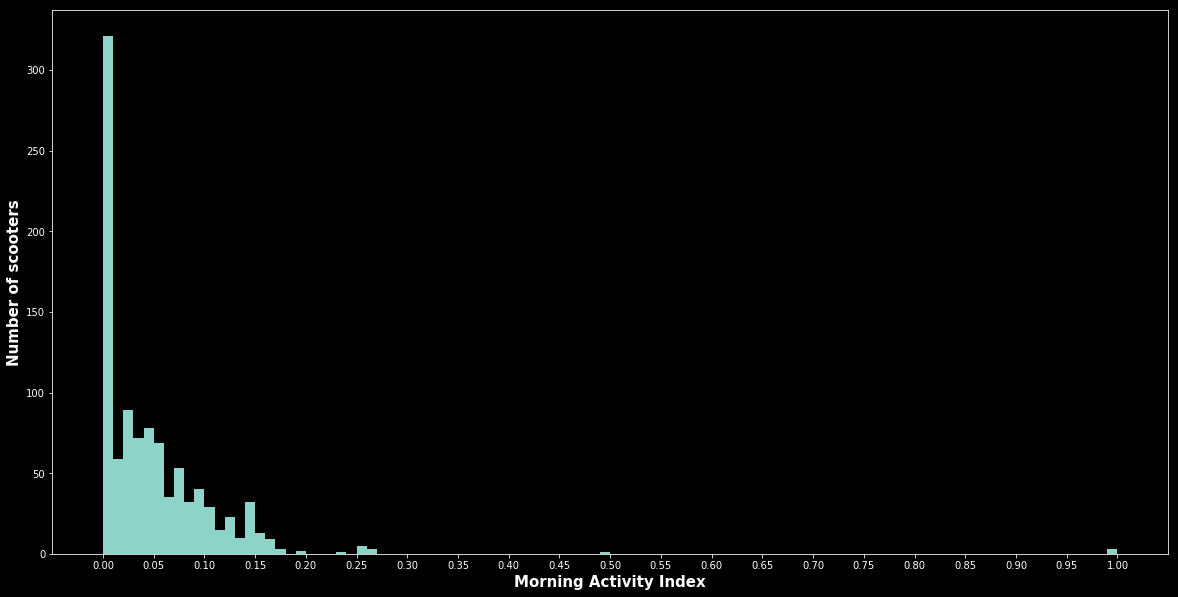

In [31]:
plt.hist(scooter_last_location.morning_activity_index, bins=100)
plt.xlabel('Morning Activity Index', fontsize = 15, fontweight='semibold')
plt.ylabel('Number of scooters', fontsize = 15, fontweight='semibold')
plt.xticks(ticks=np.arange(0, 1.05, 0.05))
plt.savefig('plots/evening_location_dist.png')
plt.show()

Now let's select the worst third.

In [32]:
cutoff = scooter_last_location.morning_activity_index.quantile(0.33)
cutoff

0.012845618824682194

In [33]:
n_scooters_reloc = len(scooter_last_location[scooter_last_location.morning_activity_index<=cutoff])
print('This means %s scooters will be relocated.'
      %n_scooters_reloc)

This means 329 scooters will be relocated.


In [34]:
print('And %s locations will be covered by the ones that can stay where they are.'
      %len(scooter_last_location[scooter_last_location.morning_activity_index>=cutoff]
           .reset_index()[['lat', 'lon']].drop_duplicates()))

And 324 locations will be covered by the ones that can stay where they are.


With this method we follow the idea of selecting the worst placed scooters and reallocating them based on the capabilities of the Operations Team.

We create an indicator for the scooters which need to be relocated.

In [35]:
scooter_last_location['relocate'] = (scooter_last_location.morning_activity_index<=cutoff)

Put scooters that stay to the side and give them the same coordinates.

In [36]:
scooter_last_location_stay = scooter_last_location[~scooter_last_location.relocate]
scooter_last_location_reloc = scooter_last_location[scooter_last_location.relocate]

In [37]:
scooter_last_location_stay['lat_new'] = scooter_last_location_stay.lat
scooter_last_location_stay['lon_new'] = scooter_last_location_stay.lon

In [38]:
scooter_last_location_stay.head()

id     lat     lon  cluster  activity_index  morning_activity_index  \
1  ACODMP  48.209  16.380        0        0.295642                0.153219   
2  ADIBPW  48.200  16.361        0        0.533503                0.091286   
3  ADKPIH  48.217  16.363        0        0.271056                0.073293   
4  ADULSM  48.215  16.354        0        0.192193                0.069899   
5  AEFUPX  48.216  16.367        0        0.111473                0.034235   

   relocate  lat_new  lon_new  
1     False   48.209   16.380  
2     False   48.200   16.361  
3     False   48.217   16.363  
4     False   48.215   16.354  
5     False   48.216   16.367

We define the optimal number of scooters per location via the following formula:
>`n_scooters_opt = (morning_count + early_peak) ** sqrt(activity_index)`

We want to use morning count (domain knowledge) together with the actual morning rents weighted by the overall activity of the day. We take the square root of the index because of its large positive outliers.

The number of scooters needed to be put into an area is then the following:
>`n_scooters_need = max(n_scooters_opt - evening_count, 0)`

In [39]:
features_location['n_scooters_opt'] = round((features_location.morning_count+features_location.early_peak)
                                            **(np.sqrt(features_location.activity_index)))
features_location['n_scooters_need'] = (features_location.n_scooters_opt-features_location.evening_count).clip(lower=0)

In [40]:
target_locations = features_location.sort_values('morning_activity_index', 
                                                 ascending=False)[['morning_count', 'evening_count',
                                                                   'morning_activity_index', 'activity_index',
                                                                   'n_scooters_opt', 'n_scooters_need']]

In [41]:
target_locations['need_cumsum'] = target_locations.n_scooters_need.cumsum()

Restrict to the areas we can distribute to.

In [42]:
target_locations = target_locations[target_locations.need_cumsum<=n_scooters_reloc]\
                    .reset_index()[['lat', 'lon', 'n_scooters_need']]

In [43]:
print('The %s scooters to be relocated, will be put into %s new locations.'
      %(n_scooters_reloc, len(target_locations)))

The 329 scooters to be relocated, will be put into 48 new locations.


## Find closest location to put scooter

To keep the distance the Operation Team has to cover as low as possible, we find the closest scooters to each location via haversine approximation.

In [44]:
new_locations = allocate_scooters(scooter_last_location_reloc, target_locations)

In [45]:
scooter_last_location_reloc = scooter_last_location_reloc.merge(new_locations, how='outer')\
                                .drop(['distance', 'position'], axis=1)

In [46]:
scooter_relocation = pd.concat([scooter_last_location_stay, scooter_last_location_reloc])

In [47]:
scooter_relocation.shape

(997, 9)

Seems about right!

## Saving results

Let's save our final results for further evaluation.

In [48]:
scooter_relocation.to_csv('data/scooter_relocation.csv')